# Preparation

## Install Kornia module

In [8]:
%%capture
!pip install kornia
!pip install kornia-rs
!pip install kornia_moons --no-deps
!pip install opencv-python --upgrade

## Download image data

In [9]:
import io
import requests

def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    bytesio = io.BytesIO(requests.get(url).content)
    
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())
    
    return filename

url_a = "https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg"
url_b = "https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg"

download_image(url_a)
download_image(url_b)

'kn_church-8.jpg'

## Import libraries and dependencies

In [10]:
# Import primary functions
import cv2
import torch
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np

# Import secondary functions
from kornia.feature.adalam import AdalamFilter
from kornia_moons.viz import *

# Display the device configuration
device = K.utils.get_cuda_or_mps_device_if_available()
print(device)

cpu


# LightGlue's image matching implementation

## 1st step: Use LightGlue w/provided Kornia's LightGlueMatcher interface

In [11]:
fname1 = "kn_church-2.jpg"
fname2 = "kn_church-8.jpg"

lg_matcher = KF.LightGlueMatcher("disk").eval().to(device)

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

num_features = 2048

disk = KF.DISK.from_pretrained("depth").to(device)

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

with torch.inference_mode():
    inp = torch.cat([img1, img2], dim=0)
    features1, features2 = disk(inp, num_features, pad_if_not_divisible=True)
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors
    lafs1 = KF.laf_from_center_scale_ori(kps1[None], torch.ones(1, len(kps1), 1, 1, device=device))
    lafs2 = KF.laf_from_center_scale_ori(kps2[None], torch.ones(1, len(kps2), 1, 1, device=device))
    dists, idxs = lg_matcher(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2)
    
    print(f"{idxs.shape[0]} tentative matches w/DISK LightGlue algorithm")

Loaded LightGlue model
340 tentative matches w/DISK LightGlue algorithm


## 2nd step: Define tentative matching functions

In [12]:
lg = KF.LightGlue("disk").to(device).eval()

image0 = {
    "keypoints": features1.keypoints[None],
    "descriptors": features1.descriptors[None],
    "image_size": torch.tensor(img1.shape[-2:][::-1]).view(1, 2).to(device)
}

image1 = {
    "keypoints": features2.keypoints[None],
    "descriptors": features2.descriptors[None],
    "image_size": torch.tensor(img2.shape[-2:][::-1]).view(1, 2).to(device)
}

with torch.inference_mode():
    out = lg({"image0": image0, "image1": image1})
    idxs = out["matches"][0]
    
    print(f"{idxs.shape[0]} tentative matches w/DISK LightGlue algorithm")

Loaded LightGlue model
340 tentative matches w/DISK LightGlue algorithm


## 3rd step: Fundamental matrix

In [13]:
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    
    return mkpts1, mkpts2

mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(),
    mkpts2.detach().cpu().numpy(),
    cv2.USAC_MAGSAC,
    1.0,
    0.999,
    100000
)

inliers = inliers > 0

print(f"{inliers.sum()} inliers with DISK")

171 inliers with DISK


## 4th step: Inliers and tentative correspondences

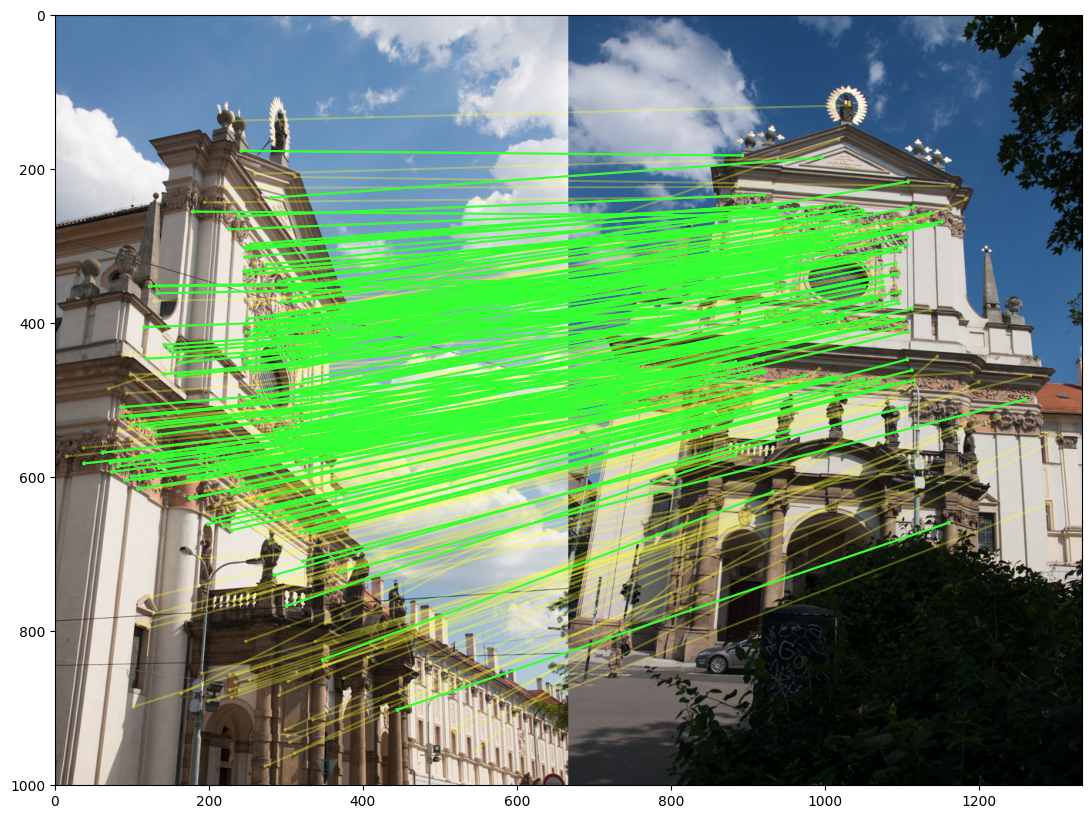

In [14]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(kps1[None].cpu()),
    KF.laf_from_center_scale_ori(kps2[None].cpu()),
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1, 1, 0.2, 0.3),
        "feature_color": None,
        "vertical": False
    }
)